In [82]:
import cv2
import time
from matplotlib import pyplot as plt
import os
from shutil import copyfile
import pandas as pd

## preprocessing and shit

In [42]:
classes = os.listdir("imgs")
print(classes)

['MT_Blowhole', 'MT_Break', 'MT_Crack', 'MT_Fray', 'MT_Free', 'MT_Uneven']


In [43]:
dirpath = lambda p : "imgs/"+p+"/Imgs" 

In [47]:
for i,classe in enumerate(classes):
    classes[i] = dirpath(classe)
print(classes)

['imgs/MT_Blowhole/Imgs', 'imgs/MT_Break/Imgs', 'imgs/MT_Crack/Imgs', 'imgs/MT_Fray/Imgs', 'imgs/MT_Free/Imgs', 'imgs/MT_Uneven/Imgs']


In [56]:
for classe in classes:
    imgs = os.listdir(classe)
    img_set = [i for i in imgs if i[-3:]=="jpg"]
    print(classe,len(img_set))
    for filename in img_set:
        this_file = classe+"/" + filename
        destination = classe[:-4] + filename
        copyfile(this_file, destination)

imgs/MT_Blowhole/Imgs 115
imgs/MT_Break/Imgs 85
imgs/MT_Crack/Imgs 57
imgs/MT_Fray/Imgs 32
imgs/MT_Free/Imgs 952
imgs/MT_Uneven/Imgs 103


In [57]:
classes = [c[:-4] for c in classes]

In [61]:
categories=[]
imgs_set = []
for c in classes : 
    files = os.listdir(c)
    for file in files:
        imgs_set.append(c+file)
        categories.append(c.split("_")[1][:-1])

In [76]:
rotated=[]
for i in range(0,len(imgs_set)):
    if not(categories[i]=="Free"):
        im=imgs_set[i]
        img = cv2.imread(im)
        img_flip_ud = cv2.flip(img, 0)
        rotated_name = im[:-4]+"fliped.jpg"
        cv2.imwrite(rotated_name, img_flip_ud)
        rotated.append(rotated_name)

In [77]:
imgs_set.extend(rotated)

In [78]:
categories.extend([c for c in categories if c!= "Free"])

In [79]:
print(len(imgs_set),len(categories))

5040 5040


In [99]:
width=[]
height=[]
for im in imgs_set:
    img = cv2.imread(im)
    width.append(img.shape[0])
    height.append(img.shape[1])

In [100]:
print(len(width),len(height))

5040 5040


In [101]:
set(width)

{630}

In [83]:
df = pd.DataFrame()
df["img_path"] = imgs_set
df["category"] = categories
df["width"] = width
df["height"] = height

In [87]:
from sklearn.utils import shuffle
df = shuffle(df)

In [88]:
df.head()

,img_path,category,width,height
575,imgs/MT_Free/exp2_num_355658.jpg,Free,376,483
3215,imgs/MT_Break/exp2_num_304305rotatedupsidedown...,Break,206,262
4833,imgs/MT_Break/exp6_num_105927rotatedupsidedown...,Break,611,252
641,imgs/MT_Free/exp3_num_1855.jpg,Free,270,250
468,imgs/MT_Free/exp2_num_148952.jpg,Free,240,609


In [89]:
df['category'].value_counts()

Free        1904
Blowhole     920
Uneven       824
Break        680
Crack        456
Fray         256
Name: category, dtype: int64

In [90]:
import matplotlib.pyplot as plt

([<matplotlib.patches.Wedge at 0x1a4ffb469c8>,
 [Text(0.4120672294154692, 1.0199022494542598, 'Free'),
  Text(-1.079263234149467, 0.21258144654045638, 'Blowhole'),
  Text(-0.6901187585430976, -0.8565839708440346, 'Uneven'),
  Text(0.2820509939256454, -1.0632249229704671, 'Break'),
  Text(0.9057614687887486, -0.6241763866549654, 'Crack'),
  Text(1.0860247796870748, -0.17478609185413077, 'Fray')])

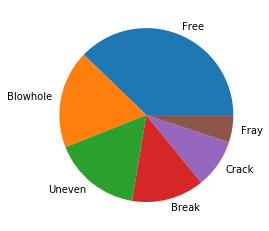

In [91]:
plt.pie(df['category'].value_counts(),labels=df['category'].value_counts().keys())

In [112]:
for file in df["img_path"]:
    img = cv2.imread(file)
    resized = cv2.resize(img, (320,320))
    cv2.imwrite(file, resized)

In [102]:
df.head()

,img_path,category,width,height
575,imgs/MT_Free/exp2_num_355658.jpg,Free,376,483
3215,imgs/MT_Break/exp2_num_304305rotatedupsidedown...,Break,206,262
4833,imgs/MT_Break/exp6_num_105927rotatedupsidedown...,Break,611,252
641,imgs/MT_Free/exp3_num_1855.jpg,Free,270,250
468,imgs/MT_Free/exp2_num_148952.jpg,Free,240,609


## model

In [97]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [104]:
datagen = ImageDataGenerator(rescale=1.0/255.)

In [120]:
generator = datagen.flow_from_dataframe(df,x_col='img_path', y_col='category',
                                                    batch_size=40,
                                                    class_mode='categorical',
                                                    target_size=(320, 320))

Found 5040 validated image filenames belonging to 6 classes.


In [121]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(320, 320, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
]) 

In [124]:
model.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [122]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 318, 318, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 159, 159, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 157, 157, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 78, 78, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 76, 76, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 38, 38, 64)      

In [108]:
from keras.callbacks import ModelCheckpoint

In [109]:
filepath = "model_weights_saved.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
desired_callbacks = [checkpoint]

In [130]:
history = model.fit(generator,
                    epochs=1,
                    verbose=1,
                    callbacks=desired_callbacks)

126/126 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 0.9980
Epoch 00001: loss did not improve from 0.02085
126/126 [==============================] - 23s 181ms/step - loss: 0.0243 - accuracy: 0.9980


In [127]:
model.save("/model/")

INFO:tensorflow:Assets written to: /model/assets
